#INFO204 Assignment 3: Supervised Learning Problem
---
*Jackson Kerr | 2942576*

[GitHub Repo](https://github.com/JacksonKerr/LinearRegression)

---



In [1]:
fast = True         # If true, uses stored graph images from GitHub repo for speed

## Setup:
Imports and helper functions.

#### Imports:

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

#### Helper functions from labs
- extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC')
- biplot(X, loadings=None, pc1=0, pc2=1, y=None, labels=None)

In [3]:
def extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC'):
    """
       take a PCA model and extract its loadings into a data frame for easier interrogation
    """
    if pipeline_component is not None:
        pca = pca[pipeline_component]
        
    X = pca.components_.T
    
    return pd.DataFrame(X, columns=[ f'{prefix}{i+1}' for i in range(X.shape[1]) ], index=feature_names)

In [4]:
def biplot(X, loadings=None, pc1=0, pc2=1, y=None, labels=None):
    """
      plot two principal components of data embedded via PCA along with their feature loadings
    """
    xs = X[:, pc1]
    ys = X[:, pc2]
    
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())    
    sns.scatterplot(x=xs*scalex, y=ys*scaley, hue=y, palette='viridis')
    
    if loadings is not None:
        n = len(loadings)
        if labels is None:
            labels = loadings.index.values
        for i in range(n):
            plt.arrow(0, 0, loadings.iloc[i, pc1], loadings.iloc[i, pc2], color='#ce2227', width=0.01, head_width=0.04)
            plt.text(loadings.iloc[i, pc1]* 1.15, loadings.iloc[i, pc2] * 1.15, labels[i], color='#ce2227', ha='center', va='center')
        
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel(f'PC{pc1+1}')
    plt.ylabel(f'PC{pc2+1}')
    plt.grid()

In [5]:
def screeplot(pca, pipeline_component=None, prefix='PC', n_components=None):
    """
        produce a plot from a PCA embedding that visualises the amount of 
        explained variance for each of the principal components 
    """
    import seaborn as sns
    from matplotlib import pyplot as plt
    
    if pipeline_component is not None:
        pca = pca[pipeline_component]

    explained_variance = pca.explained_variance_ratio_
    if n_components is not None: explained_variance = explained_variance[0:n_components]
    
    total_variance = np.cumsum(explained_variance)
    ticks = range(len(explained_variance))
    labels = [ f'{prefix}{i+1}' for i in ticks ]

    plt.bar(x=range(len(explained_variance)), height=explained_variance, label='Component')
    plt.plot(range(len(total_variance)), total_variance, 'o-', color='#ce2227', linewidth=2, label='Cumulative')
    plt.xticks(ticks=ticks, labels=labels)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.legend()

    return total_variance # Modification, return for examination

##Gettin That Data:



In [6]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [7]:
import pandas as pd

mystery_df = pd.read_csv('https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/Assignment3/mystery_train.csv', index_col=0).reset_index()

mystery_xy = mystery_df.copy()
mystery_y = mystery_xy['y']
mystery_x = mystery_xy.drop(labels=['y'], axis=1)

In [8]:
display(mystery_x.head())

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
0,72.0,0.0,0.00772,0.000040,0.00437,0.00420,0.01310,0.05514,0.506,0.03163,0.03072,0.03860,0.09490,0.018124,20.744,0.41898,0.54621,0.218980
1,56.0,1.0,0.00282,0.000012,0.00147,0.00163,0.00442,0.01663,0.154,0.00844,0.01095,0.01326,0.02531,0.012180,24.357,0.37512,0.54592,0.089372
2,74.0,1.0,0.01069,0.000057,0.00623,0.00549,0.01870,0.03469,0.304,0.01677,0.01865,0.03069,0.05032,0.017158,19.843,0.55488,0.74074,0.294060
3,66.0,1.0,0.00403,0.000018,0.00209,0.00225,0.00627,0.01644,0.146,0.00847,0.00992,0.01271,0.02540,0.016296,23.011,0.45830,0.55130,0.178600
4,73.0,0.0,0.00556,0.000044,0.00257,0.00267,0.00772,0.03634,0.362,0.01872,0.02303,0.03365,0.05615,0.030850,19.422,0.51665,0.63427,0.353550


All seem to be continuous values, except for xy, let's have a look at it.

Let's have a look at the fields.

In [9]:
mystery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      5000 non-null   float64
 1   x2      5000 non-null   float64
 2   x3      5000 non-null   float64
 3   x4      5000 non-null   float64
 4   x5      5000 non-null   float64
 5   x6      5000 non-null   float64
 6   x7      5000 non-null   float64
 7   x8      5000 non-null   float64
 8   x9      5000 non-null   float64
 9   x10     5000 non-null   float64
 10  x11     5000 non-null   float64
 11  x12     5000 non-null   float64
 12  x13     5000 non-null   float64
 13  x14     5000 non-null   float64
 14  x15     5000 non-null   float64
 15  x16     5000 non-null   float64
 16  x17     5000 non-null   float64
 17  x18     5000 non-null   float64
 18  y       5000 non-null   float64
dtypes: float64(19)
memory usage: 742.3 KB


Looks pretty standard. No missing values. All float64 decimal numbers.

## Exploratory Data Analysis

### Pairplot

Let's look at the relationships between the variables using hue="x2" as it's the only categorical variable.

In [10]:
import seaborn as sns
import numpy as np

if fast:
  # Get stored pairplot from GitHub repo
  from IPython.display import Image
  from IPython.core.display import HTML 
  img = Image(url= "https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/Assignment3/pairplot.png")
else:
  # Create directly
  img = sns.pairplot(mystery_df, hue="x2")
img

#### Correlations:

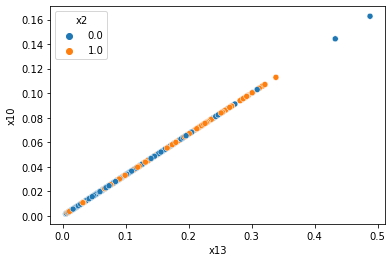

In [11]:
sns.scatterplot(x=mystery_df["x13"], y=mystery_df["x10"], hue=mystery_df["x2"])

# Remove one
to_rem = "x13"
if to_rem in mystery_df.columns:
  mystery_df = mystery_df.drop([to_rem], axis=1)

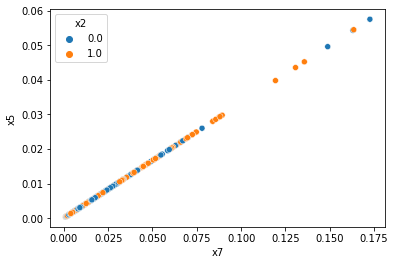

In [12]:
sns.scatterplot(x=mystery_df["x7"], y=mystery_df["x5"], hue=mystery_df["x2"])

# Remove one
to_rem = "x7"
if to_rem in mystery_df.columns:
  mystery_df = mystery_df.drop([to_rem], axis=1)

### Heatmap

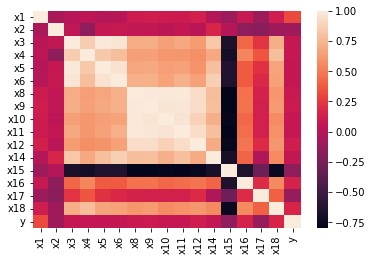

In [13]:
sns.heatmap(mystery_df.corr())

A lot of the variables are highly correlated with eachother. This was hinted at in the pairplot earlier.

### PCA Analysis

By 10 principal components, we have accounted for 99.527% of the variance in the data.


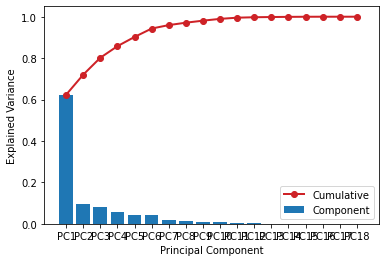

In [14]:
def find_optimal_pca_components():
  pca = PCA()
  pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
  P = pca_pipe.fit_transform(mystery_x)

  # Draw screeplot
  pca_performance = screeplot(pca)

  # Print number of components needed to account for most of the variation
  optimal_components = None
  for i in range(len(pca_performance)):
    if pca_performance[i] > 0.99:
      optimal_components = i
      print("By", i, "principal components, we have accounted for",
            str(round(pca_performance[i]*100, 3)) + "%", "of the variance in the data.")
      break
  return optimal_components
optimal_pca_components = find_optimal_pca_components()

In [15]:
# Apply PCA with optimal components to data
pca = PCA(optimal_pca_components)
optimal_pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])

P = optimal_pca_pipe.fit_transform(mystery_x)
mystery_x_pca = pd.DataFrame(P)
mystery_x_pca.columns = ["PC"+str(i+1) for i in range(len(mystery_x_pca.columns))]

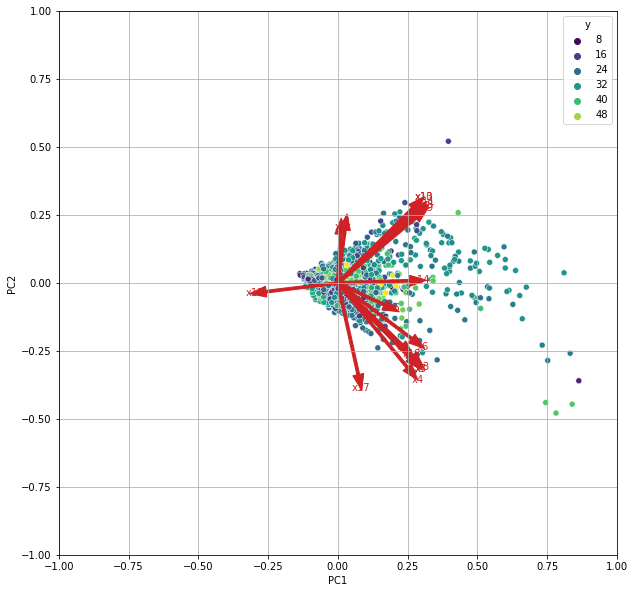

In [16]:
# Biplot
fig = plt.figure(figsize=(10, 10))
biplot(P, extract_loadings(pca, feature_names=mystery_x.columns), y=mystery_y)
plt.show()

## Split the data into training and testing sets NOT CURRENTLY USING PCA DATA

In [17]:
x_train, x_test, y_train, y_test = train_test_split(mystery_x, mystery_y, train_size=0.9, random_state=1)

## Modeling: A simple approach

In [18]:
pipe = Pipeline([("pca", "passthrough"), ("mdl", "passthrough")])

pca_options = ([PCA(optimal_pca_components)])
mdl_options = ([LinearRegression()]
            + [MLPRegressor(n) for n in [ 1, 2, 4, 6, 11, 19, 33, 59, 106, 189, 200, 223, 250]] 
            + [KNeighborsRegressor(n) for n in range(1, 15)]
            + [DecisionTreeRegressor(n) for n in range(2, 15, 2)])

tune_grids = [{'pca':pca_options, 'mdl': mdl_options}]

rkf = RepeatedKFold(n_splits=3, n_repeats=5)

scorer = make_scorer(r2_score, greater_is_better=True)

cv = GridSearchCV(pipe, tune_grids, cv=rkf, scoring=scorer, n_jobs=-1, verbose=1).fit(x_train, y_train)

Fitting 15 folds for each of 35 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed:   18.7s finished


In [19]:
cv.best_score_

0.8440014129218351

In [20]:
cv.best_params_

{'mdl': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform'),
 'pca': PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)}

In [21]:
pred = cv.best_estimator_.predict(x_test)
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred))

0.8531585140152993
15.335734546151253


# Modeling: Deep Learning Approach

In [22]:
new_my_x = pd.DataFrame(PCA(optimal_pca_components).fit_transform(mystery_x))
new_my_x.columns = [i for i in range(len(new_my_x.columns))]

x_leftover, x_test, y_leftover, y_test = train_test_split(new_my_x, mystery_y, train_size=0.90, random_state=1)
x_train, x_validation, y_train, y_validation = train_test_split(x_leftover, y_leftover, train_size=0.90, random_state=1)

In [23]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras import optimizers
import tensorflow as tf

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

def neural_network(learn_rate, num_epochs, batch_size, strat=strategy, verbose = 1):
  # Define Sequential model with 3 layers
  with strat.scope():
    model = tf.keras.models.Sequential(
        [
            layers.Dense(25, activation='relu', input_shape=(len(x_train.columns),)),
            layers.Dense(50, activation="relu", name="layer1"),
            layers.Dense(50, activation="relu", name="layer2"),
            layers.Dense(50, activation="relu", name="layer3"),
            layers.Dense(50, activation="relu", name="layer4"),
            layers.Dense(50, activation="relu", name="layer5"),
            layers.Dense(50, activation="relu", name="layer6"),
            layers.Dense(50, activation="relu", name="layer7"),
            layers.Dense(50, activation="relu", name="layer8"),
            layers.Dense(50, activation="relu", name="layer9"),
            layers.Dense(50, activation="relu", name="layer10"),
            layers.Dense(50, activation="relu", name="layer11"),
            layers.Dense(50, activation="relu", name="layer12"),
            layers.Dense(1, name="layer13"),
        ]
    )
    model.compile(optimizer="adam", loss='mse', metrics=['mae'])
  history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=num_epochs, batch_size=batch_size, verbose=verbose)
  return model, history

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.120.142.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.120.142.186:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [24]:
import matplotlib.pyplot as plt
def plot_network_performance(hist, lim1, lim2):
  history_dict = hist.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  accuracy = history_dict['mae']
  val_accuracy = history_dict['val_mae']
  
  epochs = range(1, len(loss_values) + 1)
  fig, ax = plt.subplots(2, 1, figsize=(25, 10))
  #
  # Plot the model accuracy (MAE) vs Epochs
  #
  ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_accuracy, 'r', label='Validation accuracy')
  ax[0].set_title('Training & Validation Accuracy', fontsize=16)
  ax[0].set_xlabel('Epochs', fontsize=16)
  ax[0].set_ylabel('Accuracy', fontsize=16)
  ax[0].legend()
  ax[0].set_ylim(lim1, lim2)
  #
  # Plot the loss vs Epochs
  #
  ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
  ax[1].plot(epochs, val_loss_values, 'r', label='Validation loss')
  ax[1].set_title('Training & Validation Loss', fontsize=16)
  ax[1].set_xlabel('Epochs', fontsize=16)
  ax[1].set_ylabel('Loss', fontsize=16)
  ax[1].set_ylim(lim1, lim2)
  ax[1].legend()

In [25]:
def calculate_scores(x_train, y_train, x_validation, y_validation, x_test, y_test):
  # Training Scores
  pred = model.predict(x_train)
  train_r2 = r2_score(y_train, pred)
  train_mse = mean_squared_error(y_train, pred)

  # Validation Scores
  pred = model.predict(x_validation)
  validation_r2 = r2_score(y_validation, pred)
  validation_mse = mean_squared_error(y_validation, pred)

  # Testing Scores
  pred = model.predict(x_test)
  test_r2 = r2_score(y_test, pred)
  test_mse = mean_squared_error(y_test, pred)

  return train_mse, train_r2, validation_mse, validation_r2, test_mse, test_r2

# Optimising


Epoch 1/200
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


405/405 [==============================] - 11s 15ms/step - loss: 210.2924 - mae: 11.1638 - val_loss: 81.9933 - val_mae: 7.4751
Epoch 2/200
405/405 [==============================] - 5s 13ms/step - loss: 85.9353 - mae: 7.4554 - val_loss: 80.0946 - val_mae: 7.3649
Epoch 3/200
405/405 [==============================] - 5s 13ms/step - loss: 76.1344 - mae: 6.9461 - val_loss: 59.3770 - val_mae: 5.9060
Epoch 4/200
405/405 [==============================] - 5s 13ms/step - loss: 66.7235 - mae: 6.3991 - val_loss: 62.3700 - val_mae: 6.2001
Epoch 5/200
405/405 [==============================] - 5s 13ms/step - loss: 57.6471 - mae: 5.9289 - val_loss: 52.1161 - val_mae: 5.7700
Epoch 6/200
405/405 [==============================] - 5s 13ms/step - loss: 49.6117 - mae: 5.5427 - val_loss: 46.8462 - val_mae: 5.2153
Epoch 7/200
405/405 [==============================] - 5s 13ms/step - loss: 41.9618 - mae: 5.0430 - val_loss: 36.9611 - val_mae: 4.6674
Epoch 8/200
405/405 [==============================] - 5s

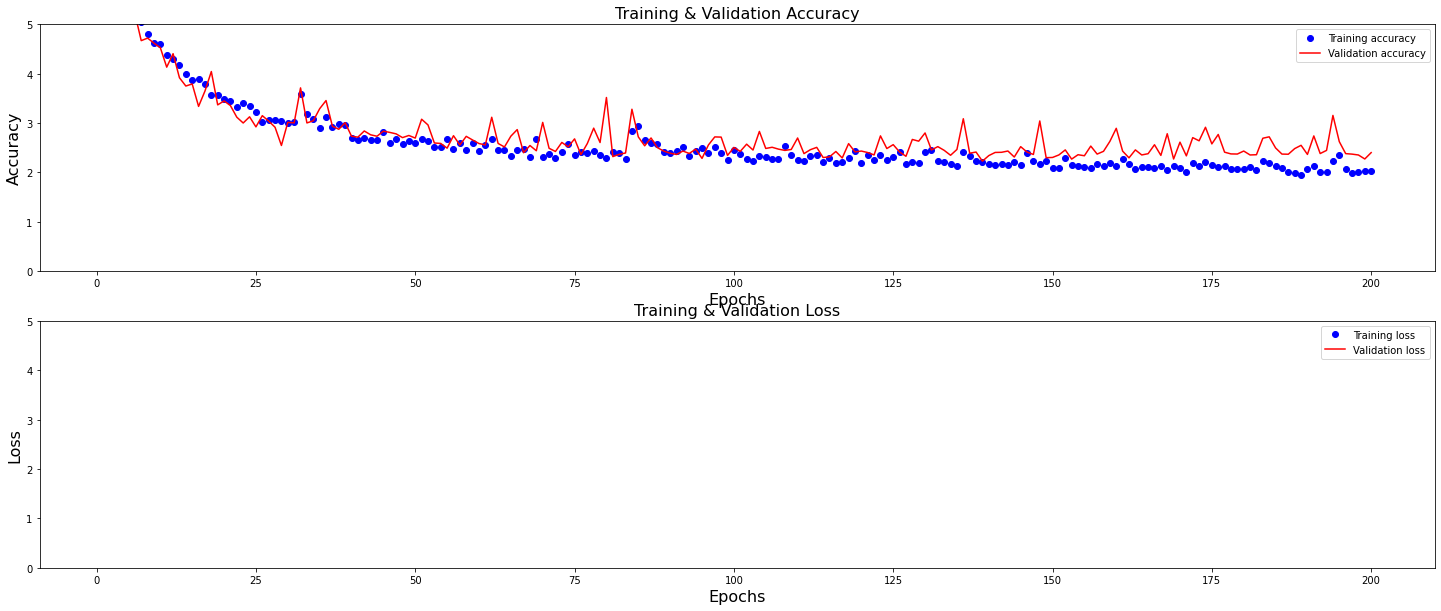

In [ ]:
# Rate, epochs, batch_size
model, history = neural_network(0.00025, 200, 10, strategy, verbose=1)
plot_network_performance(history, 0, 5)

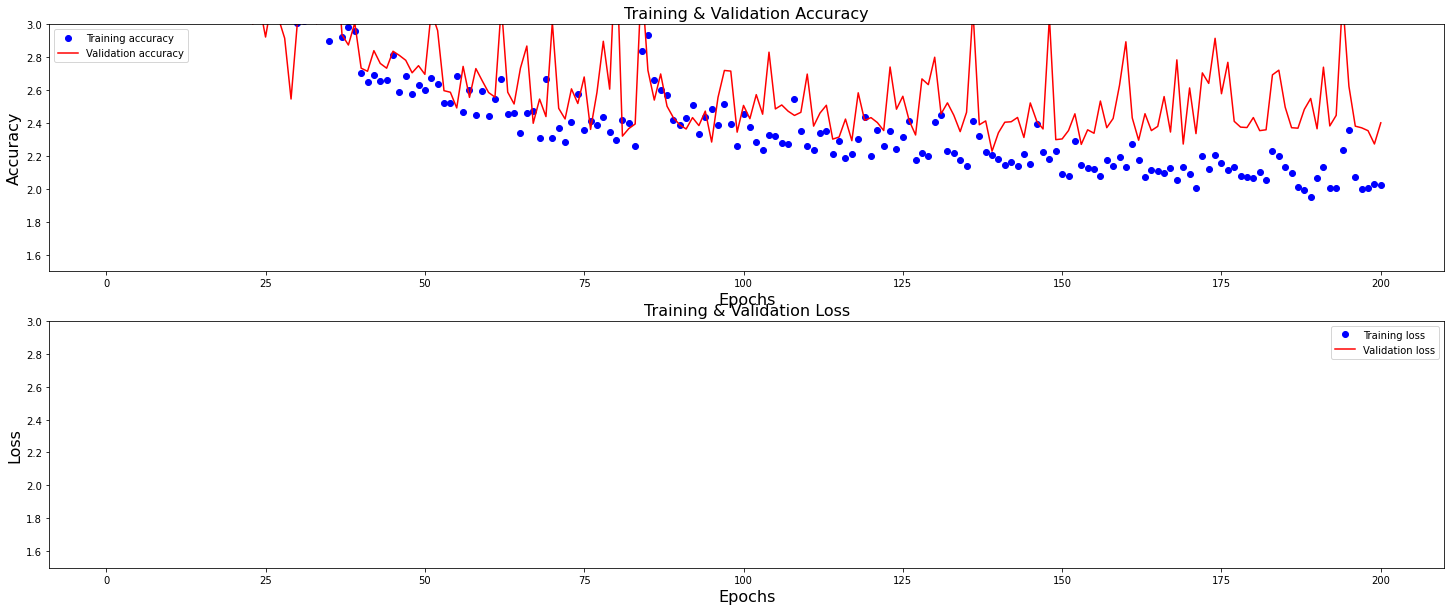

In [ ]:
plot_network_performance(history, 1.5, 3)

In [ ]:
train_mse, train_r2, validation_mse, validation_r2, test_mse, test_r2 = calculate_scores(x_train, y_train, x_validation, y_validation, x_test, y_test)
from tabulate import tabulate
print("==== Final Scores ====")
table = [['training', float(train_mse), float(train_r2)],
         ['validation', float(validation_mse), float(validation_r2)],
         ['testing', float(test_mse), float(test_r2)]]

for i in range(len(table)):
  for j in range(len(table[i])):
    if type(table[i][j]) == float:
      table[i][j] = round(table[i][j], 2)

print(tabulate(table, headers=["Scoring", 'mse', 'r2']))

==== Final Scores ====
Scoring       mse    r2
----------  -----  ----
training     7.18  0.94
validation  10.83  0.9
testing     13.13  0.87



```
model, history = neural_network(0.00025, 500, 80, strategy, verbose=1)
==== Final Scores ====
Scoring       mse    r2
----------  -----  ----
training     5.09  0.96
validation  11.83  0.89
testing     13.5   0.87
```